First, we have some boilerplate includes. These will go away once some more magics get introduced

In [1]:
from routersim.topology import Topology
from simhelpers import topology_diagram
from simhelpers import isis_sequence, isis_sequence_add_event
from simhelpers import packet_sequence, packet_sequence_add_event
from IPython.display import Image

Now we will spin up a basic topology that has 2 routers

In [2]:
topology = Topology("My Topology!")
r1 = topology.add_router("r1", interfaces=['et1', 'et2'])
r2 = topology.add_router("r2", interfaces=['et1', 'et2'])
topology.link_router_pair(r1, r2)

Let's take a loook at what it looks like. This generates a PlantUML object diagram
where each "object" is a router, and the attributes are interfaces and their point-to-point IP (with prefix len)

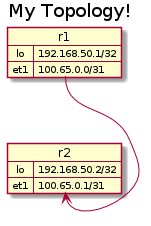

In [3]:
display(Image(topology_diagram(topology.name, topology.get_topology()).png()))

If you note above, you'll see that there is a loopback address as well as /31s on the interfaces.
This is configurable, but by default there is a pool of these which will be auto-assigned as interfaces are linked together.

And now we will enable IS-IS and converge

In [4]:
# you could of course individuall do it on the interfaces on the routers, 
# this is merely a convenience to get rid of some boilerplate
topology.isis_enable_all()

# same here, this just walks the routers and starts the isis protocol
topology.isis_start_all()

One thing to note is that nothing has really happened yet as this simulation is based on discrete movement of time
in 1ms increments. 

So what we are going to do is run for 30s and then check out the messages and events that flew around

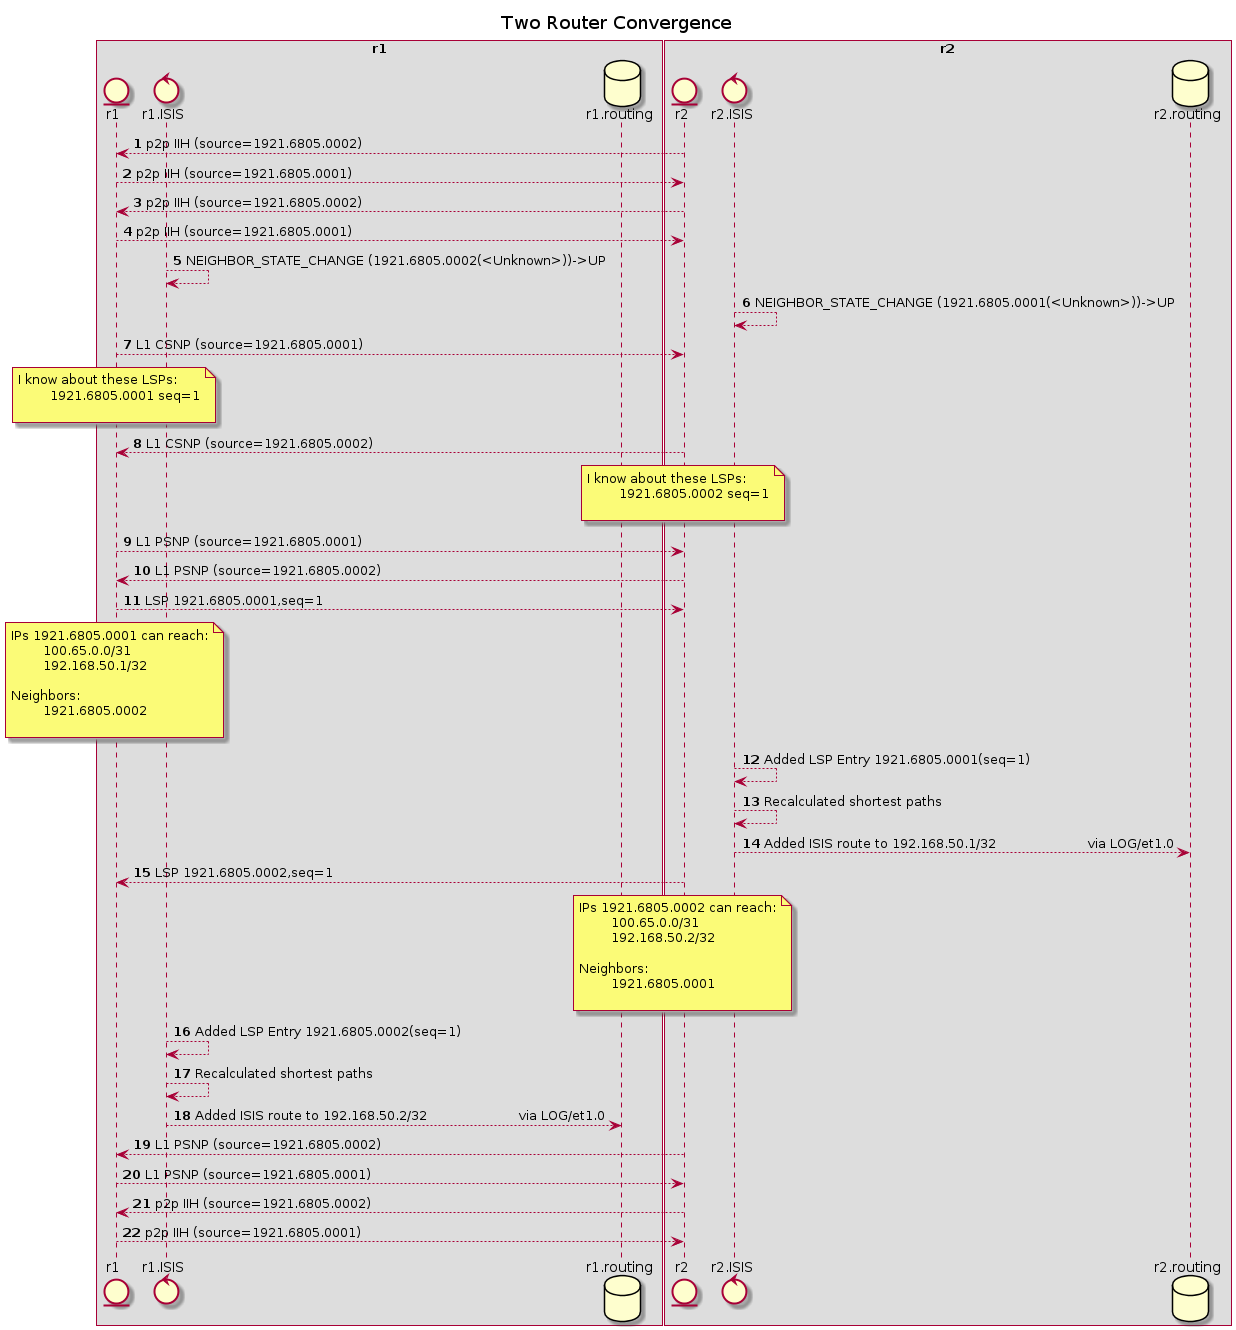

In [5]:
# run for 30s, in the future there will be something like topology.run_until(ISIS_CONVERGENCE)
# Hello events go out every 5s, so 15s should be enough for the 3-way
events = topology.run_another(15 * 1000)

# generate a Sequence diagram which knows to look for things related to IS-IS

sequence = isis_sequence("Two Router Convergence", topology.routers())

for evt_data in events:
    # this is another convenience method that knows how to filter the events
    isis_sequence_add_event(sequence,
                           evt_data[0],  # source router name
                           evt_data[1]   # the actual event data)
                           )

# now let's check it out!
display(Image(sequence.png()))

Great! We have automatically talked among the routers and you can see the *Added ISIS route* messages, corresponding
to routes that have been learned from IS-IS. Here those are going to be the Loopback and interface IPs.

Let's take a quick look at one of the routing tables (in the near future, this will show as a nice table)

In [6]:
r2.routing.print_routes()

100.65.0.0/31
	CONNECTED[/1 to None via LOG/et1.0
100.65.0.1/32
	LOCAL[/1 to None via LOG/et1.0
192.168.50.1/32
	ISIS[/20 to 192.168.50.1/32 via LOG/et1.0
192.168.50.2/32
	LOCAL[/1 to None via LOG/lo.0


So echoing what was said above, we have that r2 has learned a route to 192.168.50.1/32 via IS-IS and will go through et1.0. Looking above at the toplogy diagram this isn't terribly surprising.

Now let's add a 3rd router and get some IGP convergence. 

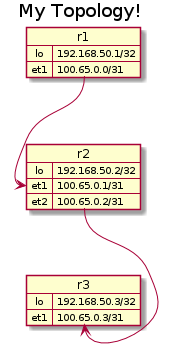

In [7]:
r3 = topology.add_router("r3", interfaces=['et1', 'et2'])
topology.link_router_pair(r2, r3)

display(Image(topology_diagram(topology.name, topology.get_topology()).png()))

And once again, let's get a sequence diagram...

Invalid state: 1921.6805.0001 is not one of our neighbors
Invalid state: 1921.6805.0001 is not one of our neighbors


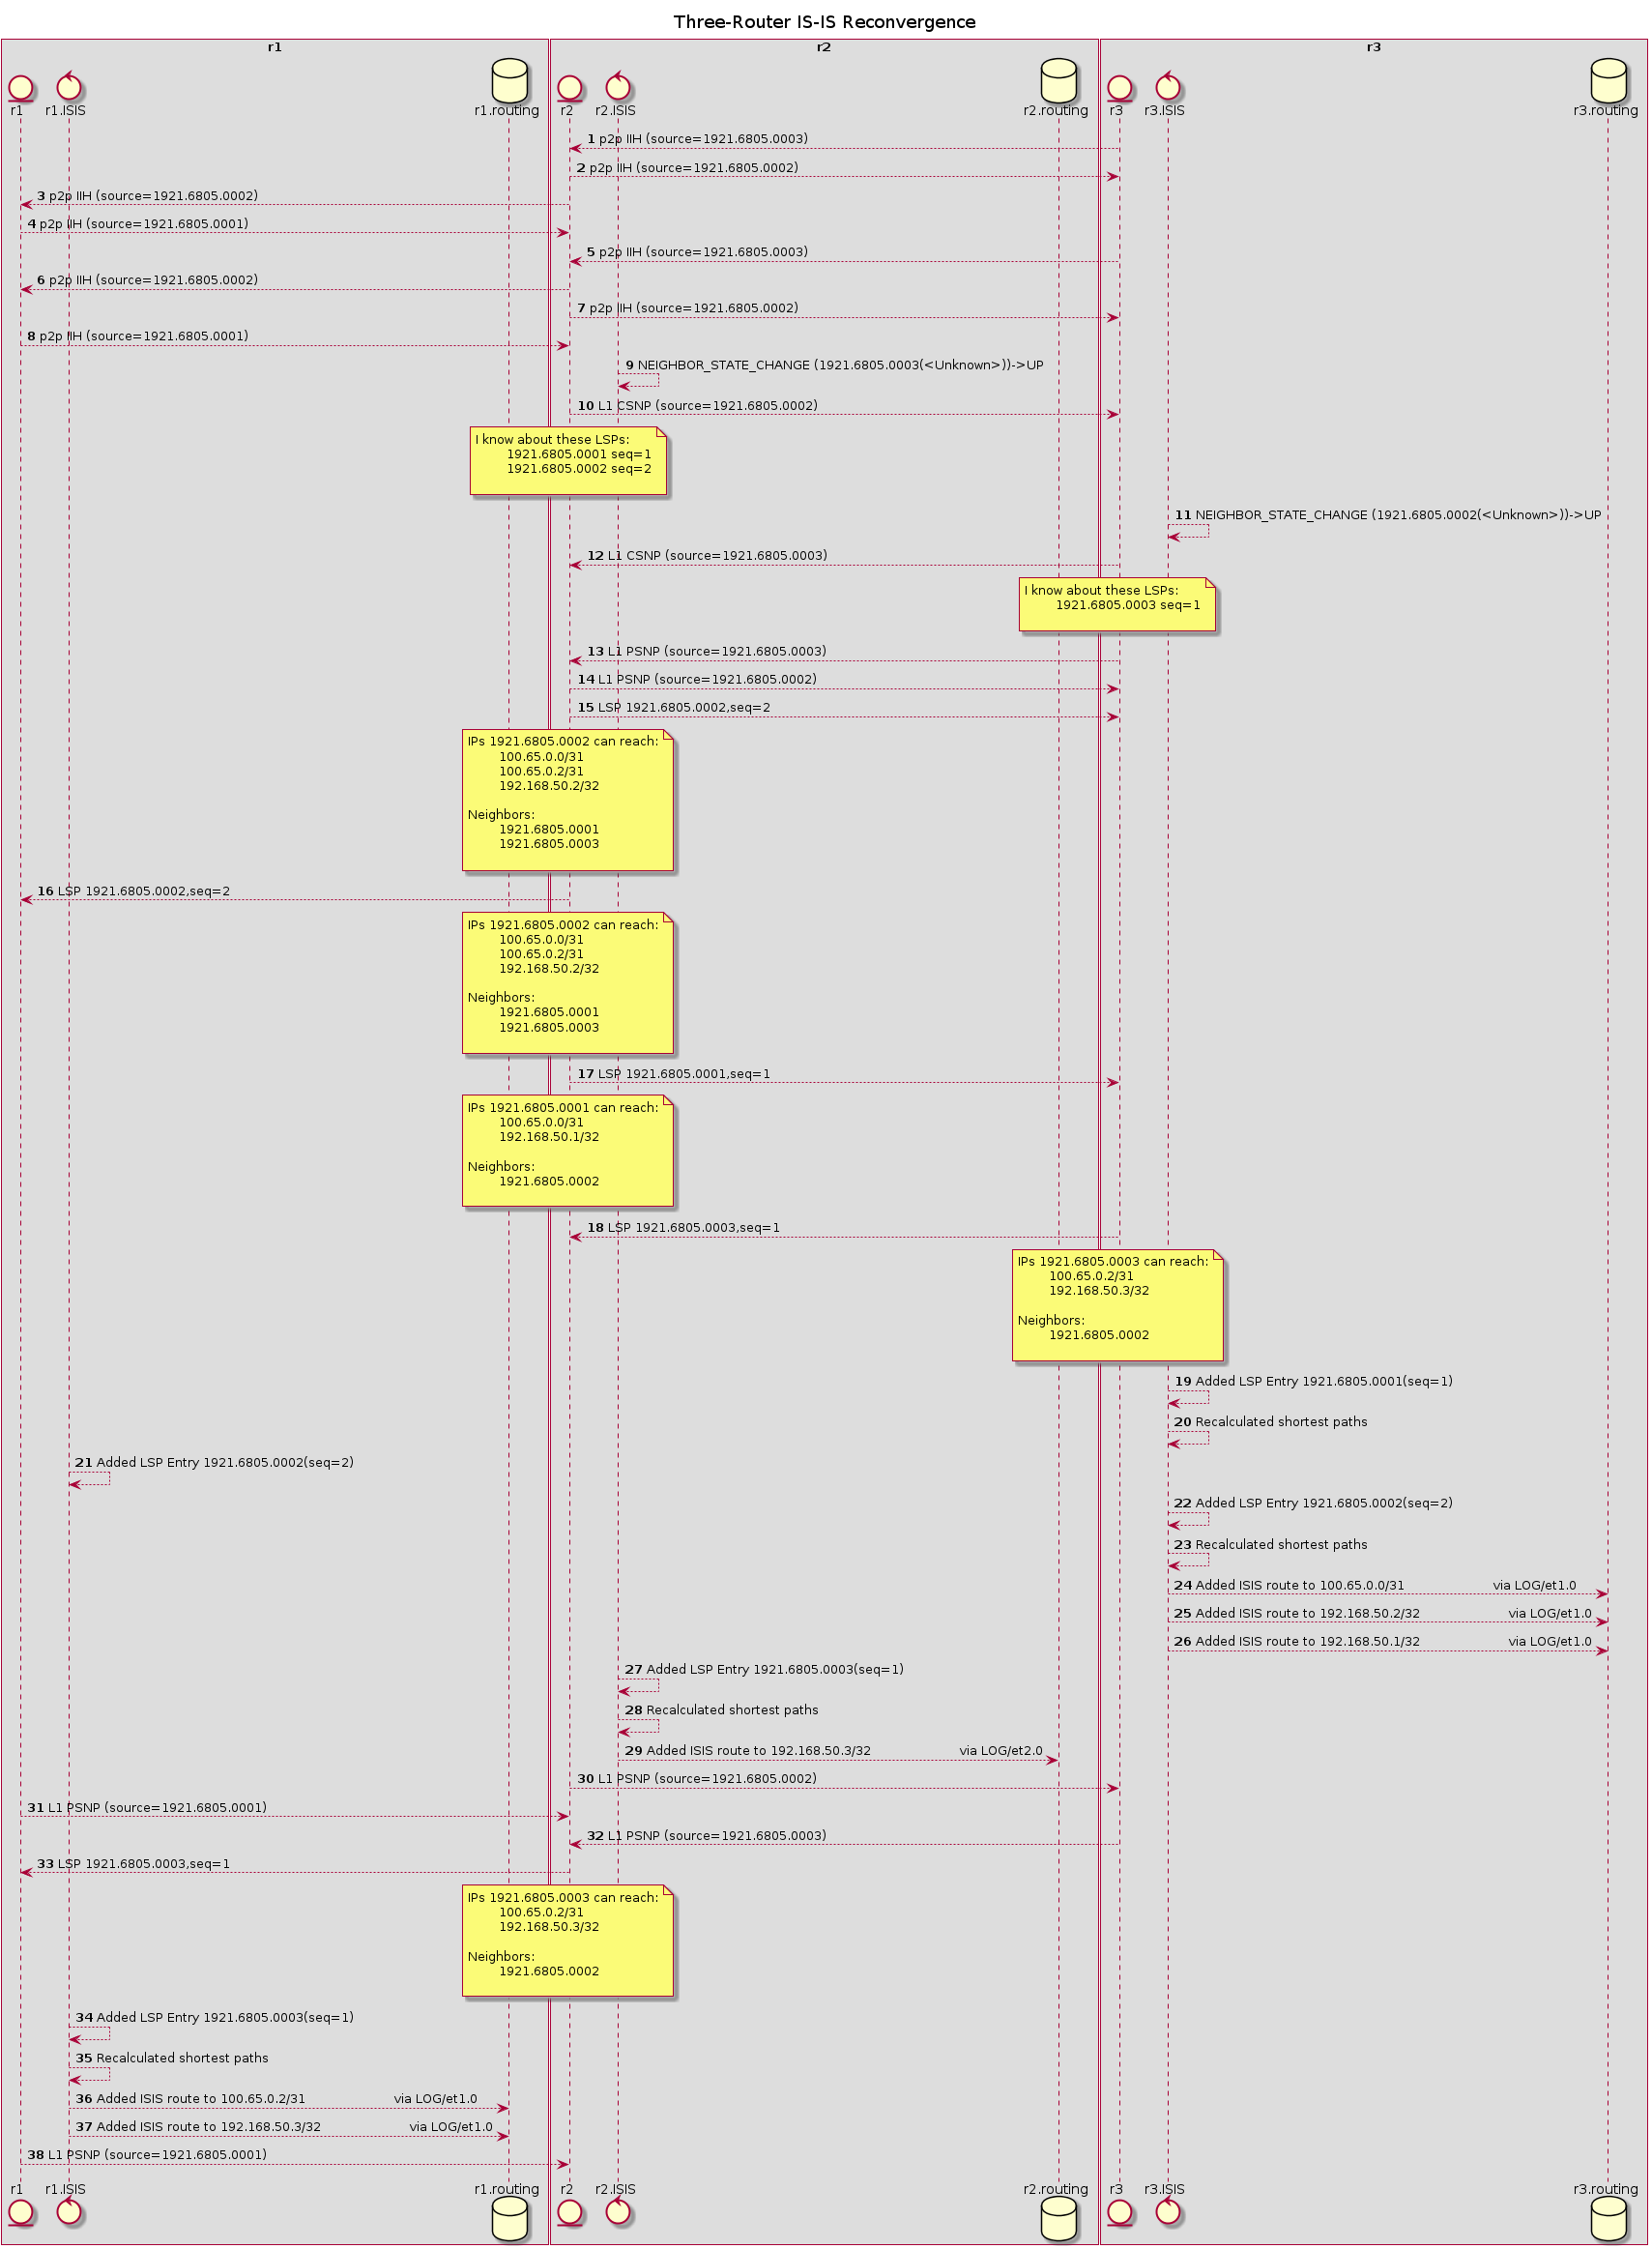

In [8]:
# IS-IS gets enabled on the logical interface (.0 of the physical interface)
r3.enable_isis(r3.interface('lo.0'), passive=True)
r3.enable_isis(r3.interface('et1.0'))

# Now this interface is active, we'll enable IS-IS here
r2.enable_isis(r2.interface('et2.0'))

r3.start_isis()

# run for 30s, in the future there will be something like topology.run_until(ISIS_CONVERGENCE)
# Hello events go out every 5s, so 15s should be enough for the 3-way
events = topology.run_another(15 * 1000)

# generate a Sequence diagram which knows to look for things related to IS-IS

sequence = isis_sequence("Three-Router IS-IS Reconvergence", topology.routers())

for evt_data in events:
    # this is another convenience method that knows how to filter the events
    isis_sequence_add_event(sequence,
                           evt_data[0],  # source router name
                           evt_data[1]   # the actual event data)
                           )

# now let's check it out!
display(Image(sequence.png()))

Cool, so we have now obtained IGP convergence with the 3 routers. One thing to notice is message numbers 16 and 17, where the _sequence number_ (seq) is now "2", as r2 is letting the world know that it's link state has changed (it has a new neighbor as well a new interface).

Let's look at the *r1* routing table. It is not directly connected to *r3*, but it should know about that router from the IS-IS learning. Recall from the topology graph that the loopback for *r3* is 192.168.50.3

In [9]:
r1.routing.print_routes()

100.65.0.0/31
	CONNECTED[/1 to None via LOG/et1.0
100.65.0.0/32
	LOCAL[/1 to None via LOG/et1.0
100.65.0.2/31
	ISIS[/20 to 192.168.50.2/32 via LOG/et1.0
192.168.50.1/32
	LOCAL[/1 to None via LOG/lo.0
192.168.50.2/32
	ISIS[/20 to 192.168.50.2/32 via LOG/et1.0
192.168.50.3/32
	ISIS[/30 to 192.168.50.2/32 via LOG/et1.0


Neat! In that last line, you can see that it is going to go vi et1.0, which is it's connection to r2

Finally, let's send a ping from r1 to r3 to make sure that packet forwarding is working and that each router knows how to get to the others.



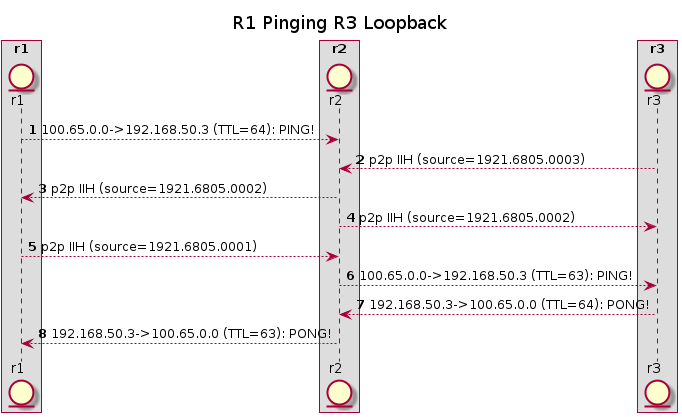

In [10]:
# Creating a new sequence diagram, intended just to show packet flow
sequence = packet_sequence("R1 Pinging R3 Loopback", topology.routers())

r1.ping("192.168.50.3")

# This should happen quite quickly, we can just run for 100ms
events = topology.run_another(500)

for evt_data in events:
    # once again, this is a convenience method that knows which event 
    # types to filter on
    packet_sequence_add_event(
            sequence,
            evt_data[0],  # source router
            evt_data[1]
    )
    
display(Image(sequence.png()))